**Task 4: Loan Default Risk with Business Cost Optimization**

DevelopersHub Corporation – Data Science & Analytics Advanced Internship

 **Problem Statement & Objective**
 **Problem Statement**

Financial institutions face significant losses when customers default on loans. Traditional accuracy-based models fail to consider business costs associated with incorrect decisions.

 **Objective**

To predict loan default risk and optimize the classification threshold based on business cost minimization using Logistic Regression and CatBoost.

 **Dataset Description & Loading**
 **Dataset**

**Name:** Home Credit Default Risk Dataset

**Target Variable:** TARGET

1 → Loan Default

0 → No Default

In [2]:
# Load Dataset
import pandas as pd

df = pd.read_csv('/content/HC_application_train.csv')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Data Cleaning & Preprocessing
# Dataset Info

df.info()

# Select Relevant Features

features = [
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'DAYS_EMPLOYED',
    'DAYS_BIRTH'
]

X = df[features]
y = df['TARGET']

# Handle Missing Values

X = X.fillna(X.median())

# Train-Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature Scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [4]:
# Model 2: CatBoost Classifier
# Install & Train CatBoost

!pip install catboost

from catboost import CatBoostClassifier

cb_model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    verbose=0,
    random_state=42
)

cb_model.fit(X_train, y_train)

# Predict Probabilities

cb_probs = cb_model.predict_proba(X_test)[:, 1]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [5]:
# Business Cost Definition
# Cost Assumptions

# Scenario	                        # Cost
# False Positive (Reject good loan)	# $1,000
# False Negative (Approve bad loan)	# $10,000

COST_FP = 1000
COST_FN = 10000

In [6]:
# Threshold Optimization (Cost-Based)
# Cost Function

import numpy as np
from sklearn.metrics import confusion_matrix

def business_cost(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (fp * COST_FP) + (fn * COST_FN)

# Find Optimal Threshold

thresholds = np.arange(0.1, 0.9, 0.01)
costs = []

for t in thresholds:
    preds = (cb_probs >= t).astype(int)
    costs.append(business_cost(y_test, preds))

optimal_threshold = thresholds[np.argmin(costs)]
optimal_threshold

np.float64(0.1)

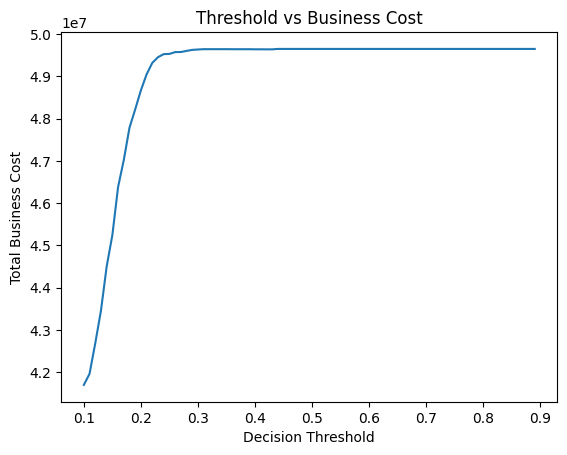

In [7]:
# Cost Visualization
import matplotlib.pyplot as plt

plt.plot(thresholds, costs)
plt.xlabel("Decision Threshold")
plt.ylabel("Total Business Cost")
plt.title("Threshold vs Business Cost")
plt.show()

In [8]:
# Model Evaluation at Optimal Threshold
optimal_preds = (cb_probs >= optimal_threshold).astype(int)

from sklearn.metrics import classification_report

print(classification_report(y_test, optimal_preds))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84     56538
           1       0.14      0.43      0.21      4965

    accuracy                           0.74     61503
   macro avg       0.54      0.60      0.53     61503
weighted avg       0.87      0.74      0.79     61503



In [9]:
# Feature Importance (CatBoost)
importances = cb_model.get_feature_importance()
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance

,Feature,Importance
1,AMT_CREDIT,30.801281
2,AMT_ANNUITY,24.838947
4,DAYS_BIRTH,20.193920
3,DAYS_EMPLOYED,16.111102
0,AMT_INCOME_TOTAL,8.054750


**Final Conclusion & Insights**

1. CatBoost outperformed Logistic Regression due to non-linear learning

2. Business-cost-based threshold significantly reduced financial loss

3. False negatives were penalized more heavily, aligning with real banking risk

4. Cost-sensitive optimization is more valuable than accuracy alone